In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import pandas as pd
import json
from dataclasses import dataclass
import numpy as np
from generation.graph import SATGraph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [3]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)
    plt.savefig(name, **kwargs)


In [4]:
@dataclass
class LoadedHistory:
    step: pd.DataFrame
    episode: pd.DataFrame


def load_history(directory: str, limit_episodes: int | None = None) -> LoadedHistory:
    step = pd.read_csv(directory + "/history_step.csv")
    episode = pd.read_csv(directory + "/history_episode.csv")

    if limit_episodes is not None:
        step = step[step["episode"] < limit_episodes]
        episode = episode[episode["episode"] < limit_episodes]

    episode["template"] = episode["template"].map(
        lambda raw_template: SATGraph.from_template(
            np.asarray(json.loads(raw_template))
        )
    )

    return LoadedHistory(step, episode)


In [5]:
h_base = load_history("../lamgate/runs/SAGE/2023-07-25T01:13:39 (base run)", limit_episodes=1500)
h_uniform = load_history("../lamgate/runs/SAGE/2023-07-25T09:32:09 (test_uniform_sampling)", limit_episodes=1500)

h_comp = load_history("../lamgate/runs/SAGE/2023-07-25T02:37:36 (comp_obs)", limit_episodes=1500)
h_int = load_history("../lamgate/runs/SAGE/2023-07-25T03:59:41 (int_rewards)", limit_episodes=1500)
h_overlaps = load_history("../lamgate/runs/SAGE/2023-07-25T15:05:36 (overlaps)", limit_episodes=1500)
h_int_overlaps = load_history("../lamgate/runs/SAGE/2023-07-25T16:11:57 (int_rewards)", limit_episodes=1500)
h_overlaps_decisions = load_history("../lamgate/runs/SAGE/2023-07-25T12:08:04 (overlaps, metric=decisions)", limit_episodes=1500)
h_int_overlaps_decisions = load_history("../lamgate/runs/SAGE/2023-07-25T13:16:55 (overlaps, int_rewards, metric=decisions)", limit_episodes=1500)


## G2SAT Sampling Performance

In [6]:
def get_perf(h: LoadedHistory):
    step = h.step.iloc[1:]
    data = []
    index = []
    for col in ("sample_pairs", "step", "predict"):
        index.append(col)
        data.append(step["timing/" + col].mean())

    # Add the logger timing
    n = len(h.step)
    index.append("logger")
    data.append(h.episode["timing/logger"].sum() / n)
    return pd.Series(data, index=index)


perf = pd.concat([get_perf(h_base), get_perf(h_uniform)], axis=1).T
perf["step"] -= perf["sample_pairs"]
perf.index = ["g2sat", "uniform"]
perf = perf.reset_index(names=["sampling_method"]).melt(
    id_vars=["sampling_method"],
    var_name="component",
    value_name="timing",
)


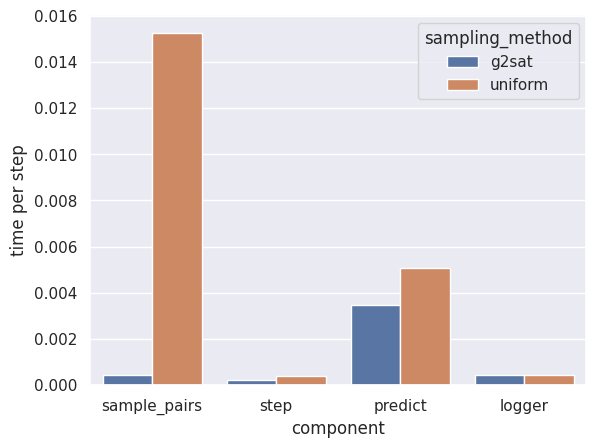

In [7]:
sns.barplot(x="component", y="timing", hue="sampling_method", data=perf)
plt.ylabel("time per step")
savefig("figs/perf_comparison_sampling.png")

## Results

In [8]:
def get_metrics_per_episode(h: LoadedHistory):
    # Get the last step per episode
    df = h.step.loc[h.step.groupby("episode")["step"].idxmax()]
    metric_cols = [col for col in df.columns if col.startswith("metrics/")]
    df = df.set_index("episode")[metric_cols]
    return df.rename({col: col.split("/")[1] for col in metric_cols}, axis=1)


def plot_metrics(
    hs: dict[str, LoadedHistory],
    experiments_label="experiment",
    window_size: int = 100,
    last_episodes: int = 200,
    saveto: str | None = None,
):
    metrics = []
    metrics_end = []
    for name, h in hs.items():
        m = get_metrics_per_episode(h).rolling(window_size).mean().reset_index()
        m[experiments_label] = name
        metrics.append(m)
        metrics_end.append(m.iloc[-last_episodes:])
    metrics = pd.concat(metrics, ignore_index=True)
    metrics_end = pd.concat(metrics_end, ignore_index=True)
    plt.figure()
    sns.lineplot(x="episode", y="time_cpu", hue=experiments_label, data=metrics)
    plt.ylabel(f"Moving avg. of CPU Time (window size={window_size})")
    plt.xlabel("Episode")
    if saveto:
        savefig(saveto + "-lineplot.png")

    first = list(hs.keys())[0]
    for col in ("conflicts", "decisions", "propagations", "restarts", "time_cpu"):
        metrics_end[col] /= metrics_end[metrics_end[experiments_label] == first][col].mean()
    metrics_end = (
        metrics_end.groupby(experiments_label)
        .mean(numeric_only=True)
        .reset_index()
        .melt(id_vars=[experiments_label, "episode"], var_name="metric")
    )
    plt.figure()
    ax = sns.barplot(x="metric", y="value", hue=experiments_label, data=metrics_end, hue_order=list(hs.keys()))
    sns.move_legend(ax, "center right")
    plt.xlabel("Metric")
    plt.ylabel(f"Average over last {last_episodes} episodes")
    if saveto:
        savefig(saveto + "-barplot.png")


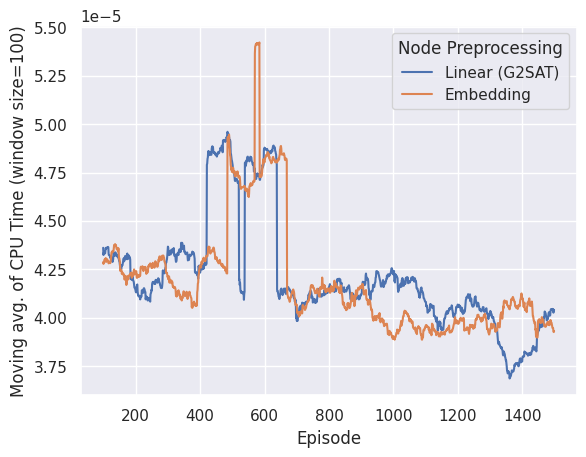

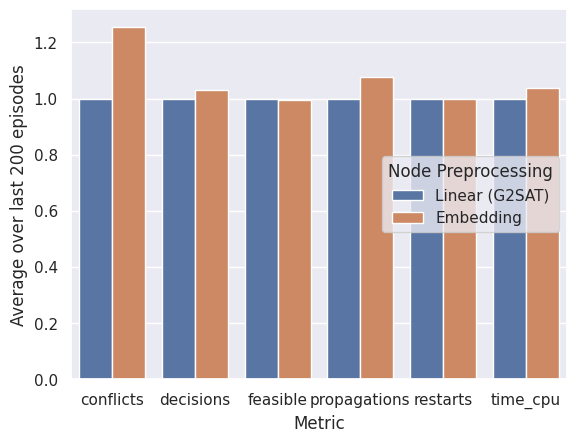

In [9]:
# Embedding
plot_metrics({"Linear (G2SAT)": h_base, "Embedding": h_comp}, experiments_label="Node Preprocessing", saveto="figs/metrics_embedding")

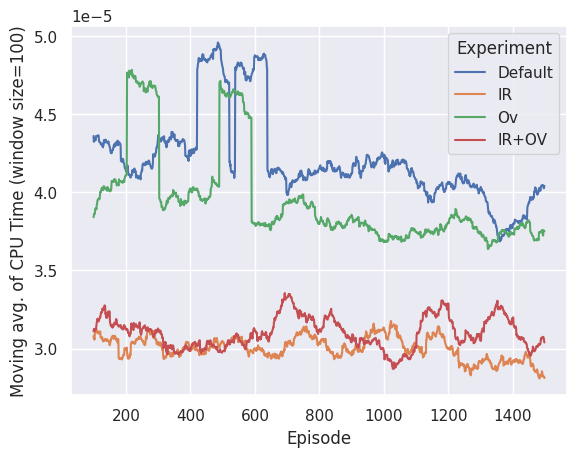

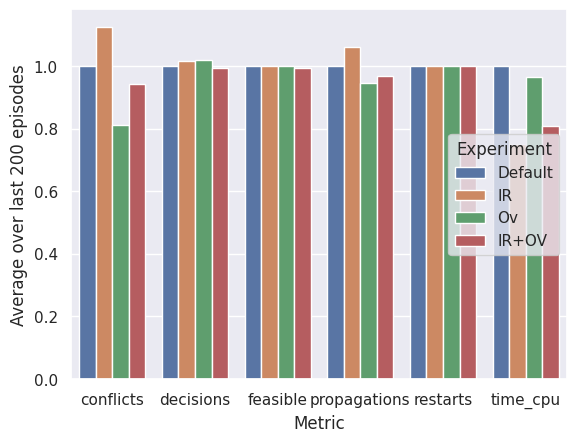

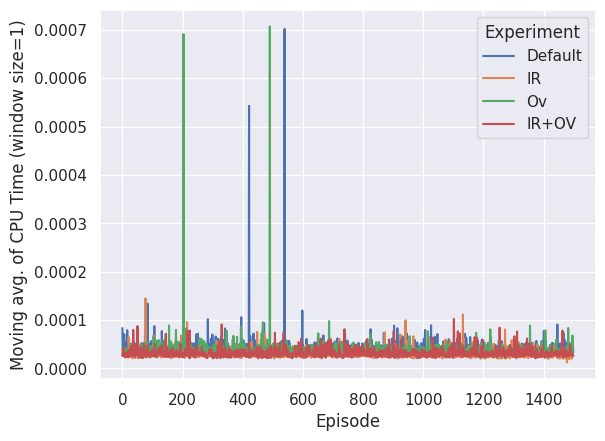

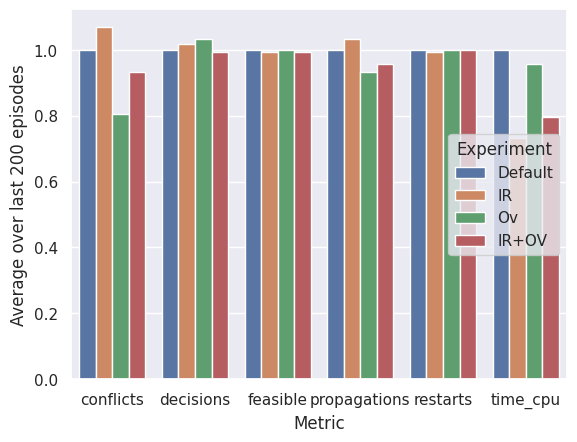

In [12]:
# IR/OV
plot_metrics({"Default": h_base, "IR": h_int, "Ov": h_overlaps, "IR+OV": h_int_overlaps}, experiments_label="Experiment", saveto="figs/metrics_ir_ov")
plot_metrics({"Default": h_base, "IR": h_int, "Ov": h_overlaps, "IR+OV": h_int_overlaps}, experiments_label="Experiment", saveto="figs/metrics_ir_ov_w1", window_size=1)


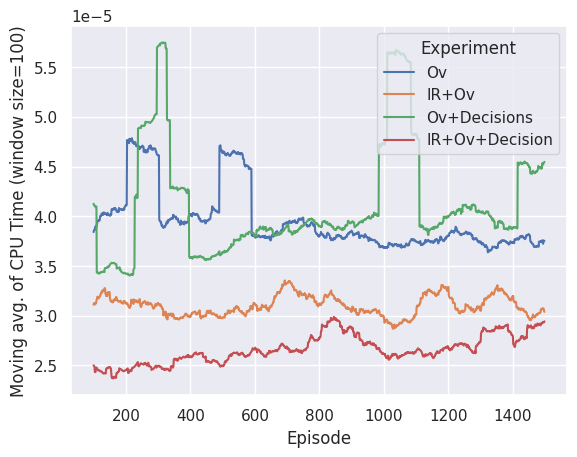

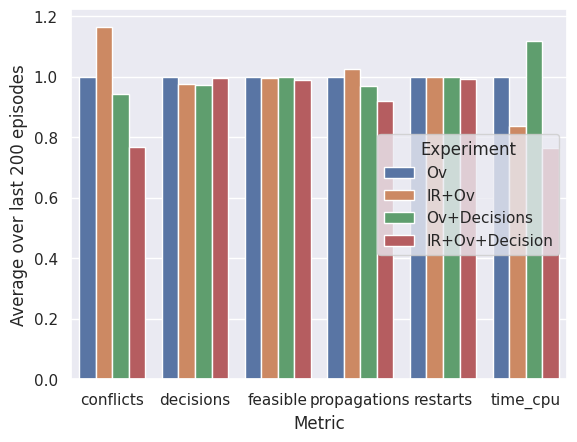

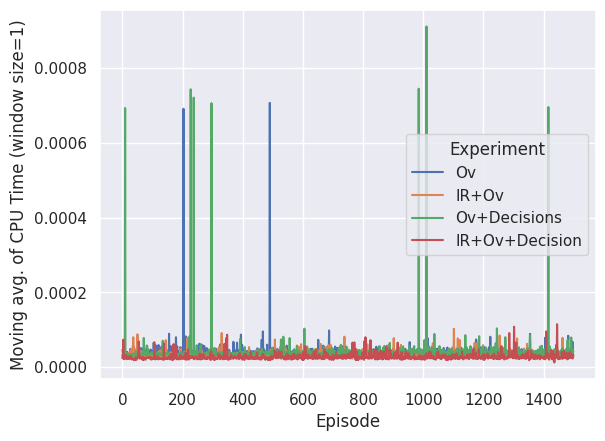

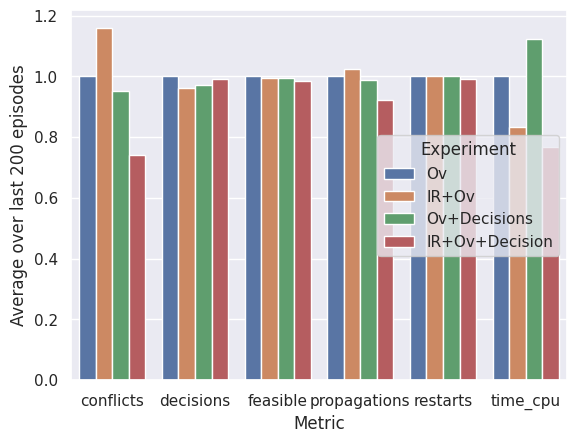

In [11]:
# IR/OV
plot_metrics({"Ov": h_overlaps, "IR+Ov": h_int_overlaps, "Ov+Decisions": h_overlaps_decisions, "IR+Ov+Decision": h_int_overlaps_decisions}, experiments_label="Experiment", saveto="figs/metrics_decision")
plot_metrics({"Ov": h_overlaps, "IR+Ov": h_int_overlaps, "Ov+Decisions": h_overlaps_decisions, "IR+Ov+Decision": h_int_overlaps_decisions}, experiments_label="Experiment", saveto="figs/metrics_decision_w1", window_size=1)